<font color='red'>Updates to Overview Tutorial </font>

## Overview

This notebook is designed to provide a broad overview of Hail's functionality, with emphasis on the functionality to manipulate and query a genetic dataset. We walk through a genome-wide SNP association test, and demonstrate the need to control for confounding caused by population stratification.

Each notebook starts the same: we import the `hail2` package and create a [HailContext](https://hail.is/hail/hail.HailContext.html). This object is the entry point for most Hail functionality.


In [1]:
from hail2 import *
hc = HailContext()

Running on Apache Spark version 2.0.2
SparkUI available at http://10.1.7.107:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version devel-69e62e8


If the above cell ran without error, we're ready to go! 

Before using Hail, we import some standard Python libraries for use throughout the notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

 Installing and importing [seaborn](http://seaborn.pydata.org/installing.html) is optional; it just makes the plots prettier.

In [3]:
# optional
import seaborn

## Check for tutorial data or download if necessary

This cell downloads the necessary data from Google Storage if it isn't found in the current working directory.

In [4]:
import os
if os.path.isdir('data/1kg.vds') and os.path.isfile('data/1kg_annotations.txt'):
    print('All files are present and accounted for!')
else:
    import sys
    sys.stderr.write('Downloading data (~16MB) from Google Storage...\n')
    import urllib
    import tarfile
    urllib.urlretrieve('https://storage.googleapis.com/hail-tutorial/hail-tutorial-data-v4.tar.gz',
                       'hail-tutorial-data-v4.tar.gz')
    sys.stderr.write('Download finished!\n')
    sys.stderr.write('Extracting...\n')
    tarfile.open('hail-tutorial-data-v4.tar.gz').extractall()
    if not (os.path.isfile('data/1kg.vcf.bgz') and os.path.isfile('data/1kg_annotations.txt')):
        raise RuntimeError('Something went wrong!')
    
    sys.stderr.write('Importing data...\n')
    (hc.import_vcf('data/1kg.vcf.bgz')
     .write('data/1kg.vds'))
    sys.stderr.write('Done!\n')

All files are present and accounted for!


## Loading data from disk

<del>Hail has its own internal data representation, called a Variant Dataset (VDS). This is both an on-disk file format and a [Python object](https://hail.is/hail/hail.VariantDataset.html). See the [overview](https://hail.is/hail/overview.html) for a complete story. Here, we read a VDS from disk.</del>

Hail has its own internal data representation, called a MatrixTable. This is both an on-disk file format <font color='red'>(MatrixTable still uses .vds file format?)</font>and a [Python object](https://hail.is/docs/devel/api2/hail.api2.MatrixTable.html?highlight=annotate_cols#matrixtable). Here, we read a MatrixTable from disk.

This dataset was created by downsampling a public 1000 genomes VCF to about 50 MB.

In [5]:
ds = hc.read('data/1kg.vds')

## Getting to know our data

It's important to have easy ways to slice, dice, query, and summarize a dataset. Some of these methods are demonstrated below.

The [summarize](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.summarize) method is useful for providing a broad overview of the data contained in a dataset.

<font color='red'>Summarize method missing in hail2</font>

In [6]:
#vds.summarize().report()

<del>The [query_variants](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.query_variants) method is the first time we'll see the [Hail expression language](https://hail.is/hail/exprlang.html). The expression language allows for a variety of incredibly expressive queries and computations, but is probably the most complex part of Hail. See the pair of tutorials on the expression language to learn more!</del>

<del>Here, we can use `query_variants` to pull out 5 variants to see what they look like.</del>

The [rows_table](https://hail.is/docs/devel/api2/hail.api2.MatrixTable.html?highlight=rows_table#hail.api2.MatrixTable.rows_table) method can be used to get a table with all the row fields in our MatrixTable. We can use `rows_table` along with [select](https://hail.is/docs/devel/api2/hail.api2.Table.html?highlight=select#hail.api2.Table.select) to pull out 5 variants. Use the `show` method to display the variants.

In [7]:
ds.rows_table().select('v').show(5)

+-----------------+
| v               |
+-----------------+
| Variant(GRCh37) |
+-----------------+
| 1:904165:G:A    |
| 1:909917:G:A    |
| 1:986963:C:T    |
| 1:1563691:T:G   |
| 1:1707740:T:G   |
+-----------------+
showing top 5 rows



<del>There are often several ways to do something in Hail. Here are two ways to peek at the first few sample IDs:</del>

We can peek at the first few sample IDs using `cols_table`.

In [8]:
ds.cols_table().select('s').show(5)

+---------+
| s       |
+---------+
| String  |
+---------+
| HG00096 |
| HG00099 |
| HG00105 |
| HG00118 |
| HG00129 |
+---------+
showing top 5 rows



<font color='red'>Matrix Table missing an attribute for sample_ids.</font>

In [9]:
# vds.sample_ids[:5]

<del>There's a similar interface for looking at the genotypes in a dataset. We use [query_genotypes](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.query_genotypes) to look at the first few genotype calls.</del>


To look at the first few genotype calls, we can use [entries_table](https://hail.is/docs/devel/api2/hail.api2.MatrixTable.html?highlight=entries_table#hail.api2.MatrixTable.entries_table) along with `select` and `take`. 

In [10]:
ds.entries_table().select('DP','GT','AD','GQ','PL').take(5)

[Struct(DP=4, GT=0/0, AD=[4, 0], GQ=12, PL=[0, 12, 147]),
 Struct(DP=8, GT=0/0, AD=[8, 0], GQ=24, PL=[0, 24, 315]),
 Struct(DP=8, GT=0/0, AD=[8, 0], GQ=23, PL=[0, 23, 230]),
 Struct(DP=7, GT=0/0, AD=[7, 0], GQ=21, PL=[0, 21, 270]),
 Struct(DP=5, GT=0/0, AD=[5, 0], GQ=15, PL=[0, 15, 205])]

## Integrate sample annotations

Hail treats <del>variant</del> <font color='red'>row</font> and <del>sample</del> <font color='red'>column</font> annotations as first-class citizens. Annotations are usually a critical part of any genetic study. <del>Sample</del> <font color='red'>Column</font> annotations are where you'll store information about sample phenotypes, ancestry, sex, and covariates. <del>Variant</del> <font color='red'> Row</font> annotations can be used to store information like gene membership and functional impact for use in QC or analysis.

In this tutorial, we demonstrate how to take a text file and use it to annotate the samples in a <del>VDS</del> <font color='red'>MatrixTable</font>. 

iPython supports various cell "magics". The `%%sh` magic is one which interprets the cell with bash, rather than Python. We can use this to look at the first few lines of our annotation file. This file contains the sample ID, the population and "super-population" designations, the sample sex, and two simulated phenotypes (one binary, one discrete).

In [11]:
%%sh
head data/1kg_annotations.txt | column -t 

Sample   Population  SuperPopulation  isFemale  PurpleHair  CaffeineConsumption
HG00096  GBR         EUR              False     False       77.0
HG00097  GBR         EUR              True      True        67.0
HG00098  GBR         EUR              False     False       83.0
HG00099  GBR         EUR              True      False       64.0
HG00100  GBR         EUR              True      False       59.0
HG00101  GBR         EUR              False     True        77.0
HG00102  GBR         EUR              True      True        67.0
HG00103  GBR         EUR              False     True        74.0
HG00104  GBR         EUR              True      False       66.0


This file can be imported into Hail with [HailContext.import_table](https://hail.is/hail/hail.HailContext.html#hail.HailContext.import_table). This method produces a <del>[KeyTable](https://hail.is/hail/hail.KeyTable.html#hail.KeyTable)</del> [Table](https://hail.is/docs/devel/api2/hail.api2.Table.html#hail.api2.Table) object. Think of this as a Pandas or R dataframe that isn't limited by the memory on your machine -- behind the scenes, it's distributed with Spark.

In [12]:
table = hc.import_table('data/1kg_annotations.txt', impute=True)\
    .key_by('Sample')

2018-01-17 16:24:12 Hail: INFO: Reading table to impute column types
2018-01-17 16:24:13 Hail: INFO: Finished type imputation
  Loading column `Sample' as type String (imputed)
  Loading column `Population' as type String (imputed)
  Loading column `SuperPopulation' as type String (imputed)
  Loading column `isFemale' as type Boolean (imputed)
  Loading column `PurpleHair' as type Boolean (imputed)
  Loading column `CaffeineConsumption' as type Float64 (imputed)


A good way to peek at the structure of a <del>`KeyTable`</del> `Table` is to look at its `schema`. 



In [13]:
print(table.schema)

Struct{Sample:String,Population:String,SuperPopulation:String,isFemale:Boolean,PurpleHair:Boolean,CaffeineConsumption:Float64}


The Python `pprint` method makes illegible printouts pretty:

In [14]:
pprint(table.schema)

Struct{
     Sample: String,
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Float64
 }


Although we used the `%%sh` magic to look at the first lines of the table, there's a better way. <del>We can convert the table to a [Spark DataFrame](https://spark.apache.org/docs/latest/sql-programming-guide.html) and use its `.show()` method:</del> We can use the `show` method:

In [15]:
table.show(10)

+---------+------------+-----------------+----------+------------+---------------------+
| Sample  | Population | SuperPopulation | isFemale | PurpleHair | CaffeineConsumption |
+---------+------------+-----------------+----------+------------+---------------------+
| String  | String     | String          | Boolean  | Boolean    |             Float64 |
+---------+------------+-----------------+----------+------------+---------------------+
| HG00096 | GBR        | EUR             | false    | false      |         7.70000e+01 |
| HG00097 | GBR        | EUR             | true     | true       |         6.70000e+01 |
| HG00098 | GBR        | EUR             | false    | false      |         8.30000e+01 |
| HG00099 | GBR        | EUR             | true     | false      |         6.40000e+01 |
| HG00100 | GBR        | EUR             | true     | false      |         5.90000e+01 |
| HG00101 | GBR        | EUR             | false    | true       |         7.70000e+01 |
| HG00102 | GBR      

Now we'll use this table to add sample annotations to our dataset. First, we'll print the schema of the sample annotations already there:

In [16]:
pprint(ds.col_schema)

Empty


<del>We use the [annotate_samples_table](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.annotate_samples_table) method to join the table with the VDS.</del>

We use the [annotate_cols](https://hail.is/docs/devel/api2/hail.api2.MatrixTable.html?highlight=annotate_cols#hail.api2.MatrixTable.annotate_cols) method to join the table with the MatrixTable.

<font color='red'>PR needed for annotate_cols(**table[ds.s]) to work.</font>

In [17]:
ds = ds.annotate_cols(dummy = table[ds.s])
ds = ds.select_cols(*ds.dummy)

2018-01-17 16:24:13 Hail: WARN: Analysis warning: low complexity: expected an expression indexed by ['column', 'row'], found indices ['column']. Results will be broadcast along ['row'].


In [18]:
pprint(ds.col_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Float64
 }


## Query functions and the Hail Expression Language

We start by looking at some statistics of the information in our table. <del>The [query](https://hail.is/hail/hail.KeyTable.html#hail.KeyTable.query) method uses the expression language to aggregate over the rows of the table.</del> The [aggregate]() method can be used to aggregate over rows of the table.

`counter` is an aggregation function that counts the number of occurrences of each unique element. We can use this to pull out the population distribution.

In [19]:
pprint(table.aggregate(pop_count = agg.counter(table.SuperPopulation)))

{'pop_count': {u'AFR': 1018L,
               u'AMR': 535L,
               u'EAS': 617L,
               u'EUR': 669L,
               u'SAS': 661L}}


`stats` is an aggregation function that produces some useful statistics about numeric collections. We can use this to see the distribution of the CaffeineConsumption phenotype.

In [20]:
pprint(table.aggregate(caffeine_stats = agg.stats(table.CaffeineConsumption)))

{'caffeine_stats': {u'max': 83.0,
                    u'mean': 67.07599999999991,
                    u'min': 53.0,
                    u'nNotMissing': 3500L,
                    u'stdev': 4.574831269331922,
                    u'sum': 234765.99999999968}}


However, these metrics aren't perfectly representative of the samples in our dataset. Here's why:

In [21]:
table.count()

3500L

In [22]:
ds.count_cols()

284

Since there are fewer samples in our dataset than in the full thousand genomes cohort, we need to look at annotations on the dataset. <del>We can do this with [query_samples](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.query_samples).</del> We can use [aggregate_cols]() to get the metrics for only the samples in our dataset.

In [23]:
ds.aggregate_cols(pop_count = agg.counter(ds.SuperPopulation))

Struct(pop_count={u'SAS': 55L, u'EAS': 72L, u'AMR': 34L, u'AFR': 76L, u'EUR': 47L})

In [24]:
pprint(ds.aggregate_cols(caffeine_stats = agg.stats(ds.CaffeineConsumption)))

{'caffeine_stats': {u'max': 80.0,
                    u'mean': 66.80281690140849,
                    u'min': 57.0,
                    u'nNotMissing': 284L,
                    u'stdev': 4.550560152208655,
                    u'sum': 18972.00000000001}}


The functionality demonstrated in the last few cells isn't anything especially new: it's certainly not difficult to ask these questions with Pandas or R dataframes, or even Unix tools like `awk`. But Hail can use the same interfaces and query language to analyze collections that are much larger, like the set of variants. 

Here we calculate the counts of each of the 12 possible unique SNPs (4 choices for the reference base * 3 choices for the alternate base). To do this, we need to map the variants to their alternate allele, filter to SNPs, and count by unique ref/alt pair:

In [25]:
snp_counts = ds.aggregate_rows(snp_counts = agg.counter(ds.v.alt_allele()))

from collections import Counter
counts = Counter(snp_counts.snp_counts)
counts.most_common()

2018-01-17 16:24:14 Hail: WARN: converting OrderedRVD => OrderedRDD


[(AltAllele(ref='C', alt='T'), 2436L),
 (AltAllele(ref='G', alt='A'), 2387L),
 (AltAllele(ref='A', alt='G'), 1944L),
 (AltAllele(ref='T', alt='C'), 1879L),
 (AltAllele(ref='C', alt='A'), 496L),
 (AltAllele(ref='G', alt='T'), 480L),
 (AltAllele(ref='T', alt='G'), 468L),
 (AltAllele(ref='A', alt='C'), 454L),
 (AltAllele(ref='C', alt='G'), 150L),
 (AltAllele(ref='G', alt='C'), 112L),
 (AltAllele(ref='T', alt='A'), 79L),
 (AltAllele(ref='A', alt='T'), 76L)]

It's nice to see that we can actually uncover something biological from this small dataset: we see that these frequencies come in pairs. C/T and G/A are actually the same mutation, just viewed from from opposite strands. Likewise, T/A and A/T are the same mutation on opposite strands. There's a 30x difference between the frequency of C/T and A/T SNPs. Why?

The same Python, R, and Unix tools could do this work as well, but we're starting to hit a wall - the latest [gnomAD release](http://gnomad.broadinstitute.org/) publishes about 250 million variants, and that won't fit in memory on a single computer.

What about genotypes? Hail can query the collection of all genotypes in the dataset, and this is getting large even for our tiny dataset. Our 1,000 samples and 10,000 variants produce 10 million unique genotypes. The gnomAD dataset has about **5 trillion** unique genotypes.

Here we will use the `hist` aggregator to produce and plot a histogram of DP values for genotypes in our thousand genomes dataset.

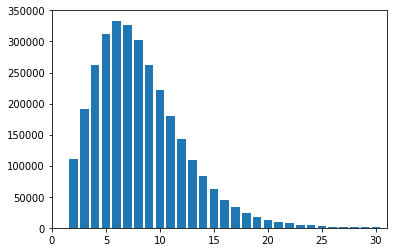

In [26]:
dp_hist = ds.aggregate_entries(dp_hist = agg.hist(ds.DP, 0, 30, 30)).dp_hist
plt.xlim(0, 31)
plt.bar(dp_hist.binEdges[1:], dp_hist.binFrequencies)
plt.show()

## Quality Control

QC is where analysts spend most of their time with sequencing datasets. QC is an iterative process, and is different for every project: there is no "push-button" solution for QC. Each time the Broad collects a new group of samples, it finds new batch effects. However, by practicing open science and discussing the QC process and decisions with others, we can establish a set of best practices as a community.

QC is entirely based on the ability to understand the properties of a dataset. Hail attempts to make this easier by providing the [sample_qc](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.sample_qc) method, which produces a set of useful metrics as sample annotations.

In [27]:
pprint(ds.col_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Float64
 }


In [28]:
ds = methods.sample_qc(ds)

2018-01-17 16:24:42 Hail: WARN: converting OrderedRVD => OrderedRDD


In [29]:
pprint(ds.col_schema)

Struct{
     Population: String,
     SuperPopulation: String,
     isFemale: Boolean,
     PurpleHair: Boolean,
     CaffeineConsumption: Float64,
     sample_qc: Struct{
         callRate: Float64,
         nCalled: Int64,
         nNotCalled: Int64,
         nHomRef: Int64,
         nHet: Int64,
         nHomVar: Int64,
         nSNP: Int64,
         nInsertion: Int64,
         nDeletion: Int64,
         nSingleton: Int64,
         nTransition: Int64,
         nTransversion: Int64,
         nStar: Int64,
         dpMean: Float64,
         dpStDev: Float64,
         gqMean: Float64,
         gqStDev: Float64,
         nNonRef: Int64,
         rTiTv: Float64,
         rHetHomVar: Float64,
         rInsertionDeletion: Float64
     }
 }


Interoperability is a big part of Hail. <del>We can pull out these new metrics to a Pandas dataframe with one line of code:</del>

To pull out these new metrics, we need to convert to a Pandas DataFrame, which can be done by first converting to a Hail1 KeyTable via the `to_hail` method, and then using the the `to_pandas` method.

<font color='red'> Missing conversion to Pandas DataFrame in Hail2</font>

In [30]:
df = ds.to_hail1().samples_table().to_pandas()

In [31]:
df.head()

,s,sa.Population,sa.SuperPopulation,sa.isFemale,sa.PurpleHair,sa.CaffeineConsumption,sa.sample_qc.callRate,sa.sample_qc.nCalled,sa.sample_qc.nNotCalled,sa.sample_qc.nHomRef,...,sa.sample_qc.nTransversion,sa.sample_qc.nStar,sa.sample_qc.dpMean,sa.sample_qc.dpStDev,sa.sample_qc.gqMean,sa.sample_qc.gqStDev,sa.sample_qc.nNonRef,sa.sample_qc.rTiTv,sa.sample_qc.rHetHomVar,sa.sample_qc.rInsertionDeletion
0,HG00096,GBR,EUR,False,False,77.0,0.979017,10731,230,6321,...,1190,0,4.566828,2.343927,22.506570,22.531111,4410,4.397479,1.190760,None
1,HG00099,GBR,EUR,True,False,64.0,0.988687,10837,124,6113,...,1229,0,8.240004,3.720313,37.523761,28.130359,4724,4.375102,1.510096,None
2,HG00105,GBR,EUR,False,False,77.0,0.995165,10908,53,6274,...,1257,0,6.711089,2.945279,31.153007,25.757756,4634,4.163087,1.496767,None
3,HG00118,GBR,EUR,True,False,64.0,0.999909,10960,1,6153,...,1298,0,11.459672,3.779678,48.738230,27.944320,4807,4.101695,1.648485,None
4,HG00129,GBR,EUR,False,False,71.0,0.985220,10799,162,6105,...,1208,0,7.425897,3.443599,35.057413,27.784722,4694,4.432119,1.512848,None


Plotting the QC metrics is a good place to start.

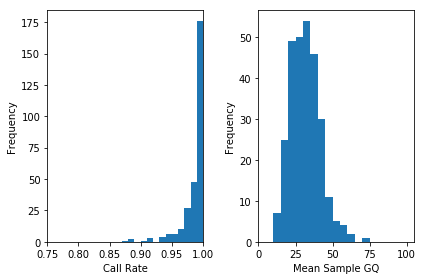

In [35]:
plt.clf()
plt.subplot(1, 2, 1)
plt.hist(df["sa.sample_qc.callRate"], bins=np.arange(.75, 1.01, .01))
plt.xlabel("Call Rate")
plt.ylabel("Frequency")
plt.xlim(.75, 1)

plt.subplot(1, 2, 2)
plt.hist(df["sa.sample_qc.gqMean"], bins = np.arange(0, 105, 5))
plt.xlabel("Mean Sample GQ")
plt.ylabel("Frequency")
plt.xlim(0, 105)

plt.tight_layout()
plt.show()

Often, these metrics are correlated.

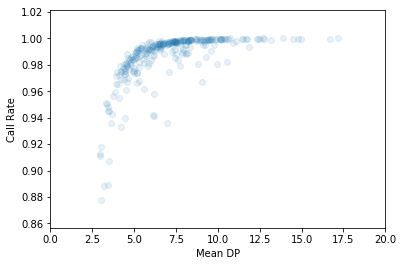

In [38]:
plt.scatter(df["sa.sample_qc.dpMean"], df["sa.sample_qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.show()

Removing outliers from the dataset will generally improve association results. We can draw lines on the above plot to indicate outlier cuts. We'll want to remove all samples that fall in the bottom left quadrant.

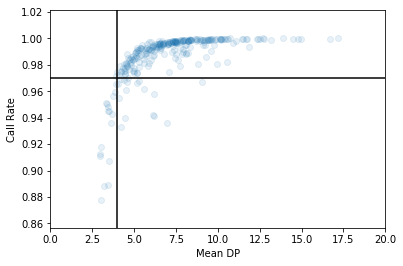

In [39]:
plt.scatter(df["sa.sample_qc.dpMean"], df["sa.sample_qc.callRate"],
            alpha=0.1)
plt.xlabel('Mean DP')
plt.ylabel('Call Rate')
plt.xlim(0, 20)
plt.axhline(0.97, c='k')
plt.axvline(4, c='k')
plt.show()

It's easy to filter when we've got the cutoff values decided:

In [40]:
ds = ds.filter_cols((ds.sample_qc.dpMean >= 4) & (ds.sample_qc.callRate >= 0.97))
print('After filter, %d/1000 samples remain.' % ds.count_cols())

After filter, 250/1000 samples remain.


Next is genotype QC. To start, we'll print the post-sample-QC call rate. It's actually gone _up_ since the initial summary - dropping low-quality samples disproportionally removed missing genotypes.

Import the `hail.expr.functions` module.

In [41]:
import hail.expr.functions as functions

call_rate = ds.aggregate_entries(call_rate = agg.fraction(functions.is_defined(ds.GT))).call_rate
print('pre QC call rate is %.3f' % call_rate)

2018-01-17 16:33:40 Hail: WARN: converting OrderedRVD => OrderedRDD


pre QC call rate is 0.992


It's a good idea to filter out genotypes where the reads aren't where they should be: if we find a genotype called homozygous reference with >10% alternate reads, a genotype called homozygous alternate with >10% reference reads, or a genotype called heterozygote without a ref / alt balance near 1:1, it is likely to be an error.

In [42]:
ab = ds.AD[1]/ds.AD.sum()

filter_condition_ab = ((ds.GT.is_hom_ref() & (ab <= 0.1)) |
                        (ds.GT.is_het() & (ab >= 0.25) & (ab <= 0.75)) |
                        (ds.GT.is_hom_var() & (ab >= 0.9)))

ds = ds.filter_entries(filter_condition_ab)

In [43]:
post_qc_call_rate = ds.aggregate_entries(post_qc_call_rate = agg.fraction(functions.is_defined(ds.GT))).post_qc_call_rate
print('post QC call rate is %.3f' % post_qc_call_rate)

2018-01-17 16:33:48 Hail: WARN: converting OrderedRVD => OrderedRDD


post QC call rate is 0.956


<del>Variant QC is a bit more of the same: we can use the [variant_qc](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.variant_qc) method to produce a variety of useful statistics, plot them, and filter.</del>

Variant QC is a bit more of the same: we can use the [row_schema](https://hail.is/docs/devel/api2/hail.api2.MatrixTable.html?highlight=row_schema#hail.api2.MatrixTable.row_schema) method to produce a variety of useful statistics, plot them, and filter.

In [44]:
pprint(ds.row_schema)

Struct{
     rsid: String,
     qual: Float64,
     filters: Set[String],
     info: Struct{
         AC: Array[Int32],
         AF: Array[Float64],
         AN: Int32,
         BaseQRankSum: Float64,
         ClippingRankSum: Float64,
         DP: Int32,
         DS: Boolean,
         FS: Float64,
         HaplotypeScore: Float64,
         InbreedingCoeff: Float64,
         MLEAC: Array[Int32],
         MLEAF: Array[Float64],
         MQ: Float64,
         MQ0: Int32,
         MQRankSum: Float64,
         QD: Float64,
         ReadPosRankSum: Float64,
         set: String
     }
 }


The [cache](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.cache) is used to optimize some of the downstream operations.

In [45]:
ds = methods.variant_qc(ds).cache()

In [46]:
pprint(ds.row_schema)

Struct{
     rsid: String,
     qual: Float64,
     filters: Set[String],
     info: Struct{
         AC: Array[Int32],
         AF: Array[Float64],
         AN: Int32,
         BaseQRankSum: Float64,
         ClippingRankSum: Float64,
         DP: Int32,
         DS: Boolean,
         FS: Float64,
         HaplotypeScore: Float64,
         InbreedingCoeff: Float64,
         MLEAC: Array[Int32],
         MLEAF: Array[Float64],
         MQ: Float64,
         MQ0: Int32,
         MQRankSum: Float64,
         QD: Float64,
         ReadPosRankSum: Float64,
         set: String
     },
     variant_qc: Struct{
         callRate: Float64,
         AC: Int32,
         AF: Float64,
         nCalled: Int32,
         nNotCalled: Int32,
         nHomRef: Int32,
         nHet: Int32,
         nHomVar: Int32,
         dpMean: Float64,
         dpStDev: Float64,
         gqMean: Float64,
         gqStDev: Float64,
         nNonRef: Int32,
         rHeterozygosity: Float64,
         rHetHomVar: Float

<font color='red'>Convert the variants to a Pandas DataFrame (by first converting to a hail1 Variant Dataset).</font>

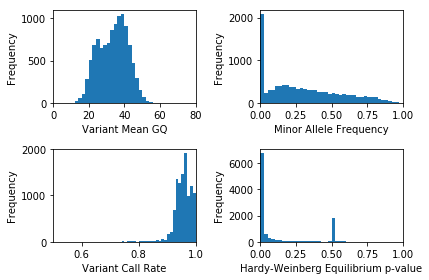

In [47]:
variant_df = ds.to_hail1().variants_table().to_pandas()

plt.clf()
plt.subplot(2, 2, 1)
variantgq_means = variant_df["va.variant_qc.gqMean"]
plt.hist(variantgq_means, bins = np.arange(0, 84, 2))
plt.xlabel("Variant Mean GQ")
plt.ylabel("Frequency")
plt.xlim(0, 80)

plt.subplot(2, 2, 2)
variant_mleaf = variant_df["va.variant_qc.AF"]
plt.hist(variant_mleaf, bins = np.arange(0, 1.05, .025))
plt.xlabel("Minor Allele Frequency")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.subplot(2, 2, 3)
plt.hist(variant_df['va.variant_qc.callRate'], bins = np.arange(0, 1.05, .01))
plt.xlabel("Variant Call Rate")
plt.ylabel("Frequency")
plt.xlim(.5, 1)

plt.subplot(2, 2, 4)
plt.hist(variant_df['va.variant_qc.pHWE'], bins = np.arange(0, 1.05, .025))
plt.xlabel("Hardy-Weinberg Equilibrium p-value")
plt.ylabel("Frequency")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()



<del>These statistics actually look pretty good: we don't need to filter this dataset. Most datasets require thoughtful quality control, though. The [filter_variants_expr](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.filter_variants_expr) method can help!</del>

These statistics actually look pretty good: we don't need to filter this dataset. Most datasets require thoughtful quality control, though. The [filter_rows](https://hail.is/docs/devel/api2/hail.api2.MatrixTable.html#hail.api2.MatrixTable.filter_rows) method can help!

## Let's do a GWAS!

First, we need to restrict to variants that are : 

 - common (we'll use a cutoff of 1%)
 - uncorrelated (not in linkage disequilibrium)
 
Both of these are easy in Hail.

<font color='red'>Missing ld_prune</font>

In [48]:
common_ds = ds.filter_rows(ds.variant_qc.AF > 0.01)

In [49]:
print('Samples: %d  Variants: %d' % (common_ds.count_cols(), common_ds.count_rows()))

Samples: 250  Variants: 9177


These filters removed about 15% of sites (we started with a bit over 10,000). This is _NOT_ representative of most sequencing datasets! We have already downsampled the full thousand genomes dataset to include more common variants than we'd expect by chance.

In Hail, the association tests accept sample annotations for the sample phenotype and covariates. Since we've already got our phenotype of interest (caffeine consumption) in the dataset, we are good to go:

In [50]:
gwas = methods.linreg(common_ds, [common_ds.CaffeineConsumption], common_ds.GT.num_alt_alleles())
pprint(gwas.row_schema)

2018-01-17 16:35:06 Hail: INFO: Running linear regression for 1 phenotype on 250 samples with 1 covariate including intercept...


Struct{
     rsid: String,
     qual: Float64,
     filters: Set[String],
     info: Struct{
         AC: Array[Int32],
         AF: Array[Float64],
         AN: Int32,
         BaseQRankSum: Float64,
         ClippingRankSum: Float64,
         DP: Int32,
         DS: Boolean,
         FS: Float64,
         HaplotypeScore: Float64,
         InbreedingCoeff: Float64,
         MLEAC: Array[Int32],
         MLEAF: Array[Float64],
         MQ: Float64,
         MQ0: Int32,
         MQRankSum: Float64,
         QD: Float64,
         ReadPosRankSum: Float64,
         set: String
     },
     variant_qc: Struct{
         callRate: Float64,
         AC: Int32,
         AF: Float64,
         nCalled: Int32,
         nNotCalled: Int32,
         nHomRef: Int32,
         nHet: Int32,
         nHomVar: Int32,
         dpMean: Float64,
         dpStDev: Float64,
         gqMean: Float64,
         gqStDev: Float64,
         nNonRef: Int32,
         rHeterozygosity: Float64,
         rHetHomVar: Float

Looking at the bottom of the above printout, you can see the linear regression adds new variant annotations for the beta, standard error, t-statistic, and p-value.

In [51]:
def qqplot(pvals, xMax, yMax):
    spvals = sorted(filter(lambda x: x and not(isnan(x)), pvals))
    exp = [-log(float(i) / len(spvals), 10) for i in np.arange(1, len(spvals) + 1, 1)]
    obs = [-log(p, 10) for p in spvals]
    plt.clf()
    plt.scatter(exp, obs)
    plt.plot(np.arange(0, max(xMax, yMax)), c="red")
    plt.xlabel("Expected p-value (-log10 scale)")
    plt.ylabel("Observed p-value (-log10 scale)")
    plt.xlim(0, xMax)
    plt.ylim(0, yMax)
    plt.show()

Python makes it easy to make a [Q-Q (quantile-quantile) plot](https://en.wikipedia.org/wiki/Q-Q_plot).

2018-01-17 16:35:18 Hail: WARN: converting OrderedRVD => OrderedRDD


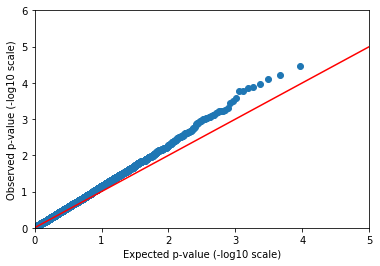

In [52]:
qqplot(gwas.aggregate_rows(pvals = agg.collect(gwas.linreg.pval[0])).pvals, 5, 6)

## Confounded!

The observed p-values drift away from the expectation immediately. Either every SNP in our dataset is causally linked to caffeine consumption (unlikely), or there's a confounder.

We didn't tell you, but sample ancestry was actually used to simulate this phenotype. This leads to a [stratified](https://en.wikipedia.org/wiki/Population_stratification) distribution of the phenotype. The solution is to include ancestry as a covariate in our regression. 

The <del>[linreg](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.linreg)</del> [linreg](https://hail.is/docs/devel/methods/index.html?highlight=linreg#hail.methods.linreg) method can also take sample annotations to use as covariates. We already annotated our samples with reported ancestry, but it is good to be skeptical of these labels due to human error. Genomes don't have that problem! Instead of using reported ancestry, we will use genetic ancestry by including computed principal components in our model.

The <del>[pca](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.pca)</del> [pca](https://hail.is/docs/devel/methods/index.html#hail.methods.pca) method produces eigenvalues as a list and sample PCs as a KeyTable, and can also produce variant loadings when asked. The <del>[pca_of_normalized_genotypes](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.pca_of_normalized_genotypes)</del> [hwe_normalized_pca](https://hail.is/docs/devel/methods/index.html#hail.methods.hwe_normalized_pca) method does the same, using HWE-normalized genotypes for the PCA.

In [54]:
pca_eigenvalues, pca_scores, _ = methods.hwe_normalized_pca(common_ds)

2018-01-17 16:41:36 Hail: INFO: Running PCA using 9169 variants.
2018-01-17 16:41:36 Hail: INFO: Running PCA with 10 components...


In [55]:
pprint(pca_eigenvalues)

[23.66115135007735,
 11.398548752781213,
 3.631737419697766,
 2.7576029831927085,
 1.5880710806320033,
 1.5108402358523811,
 1.4858366372836007,
 1.4578937514801846,
 1.4430113601324204,
 1.421810008138029]


In [56]:
pprint(pca_scores)

is.hail.table.Table@2b72f26e


Now that we've got principal components per sample, we may as well plot them! Human history exerts a strong effect in genetic datasets. Even with a 50MB sequencing dataset, we can recover the major human populations.

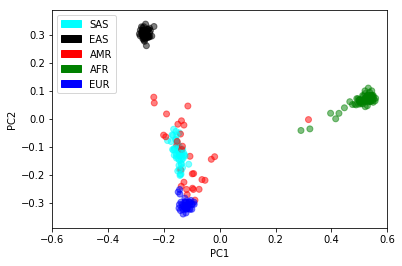

In [57]:
pca_table = pca_scores.join(common_ds.cols_table()).to_hail1().to_pandas()

colors = {'AFR': 'green', 'AMR': 'red', 'EAS': 'black', 'EUR': 'blue', 'SAS': 'cyan'}
plt.scatter(pca_table["pcaScores.PC1"], pca_table["pcaScores.PC2"], 
            c = pca_table["SuperPopulation"].map(colors), 
            alpha = .5)
plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
plt.show()

Now we can rerun our linear regression, controlling for the first few principal components and sample sex.

In [58]:
cds = common_ds.annotate_cols(pca = pca_scores[common_ds.s])

linreg_results = methods.linreg(cds, [cds.CaffeineConsumption], cds.GT.num_alt_alleles(),
                                covariates=[cds.pca.PC1, cds.pca.PC2, cds.pca.PC3, cds.isFemale])

pvals = linreg_results.aggregate_rows(pvals=agg.collect(linreg_results.linreg.pval[0])).pvals

2018-01-17 16:42:20 Hail: WARN: Analysis warning: low complexity: expected an expression indexed by ['column', 'row'], found indices ['column']. Results will be broadcast along ['row'].
2018-01-17 16:42:21 Hail: INFO: Running linear regression for 1 phenotype on 250 samples with 5 covariates including intercept...
2018-01-17 16:42:21 Hail: WARN: converting OrderedRVD => OrderedRDD


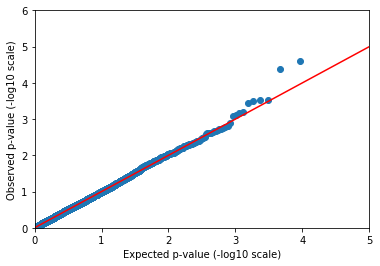

In [59]:
qqplot(pvals, 5, 6)

<font color='red'> missing assertion that PL's length is 3</font>

In [60]:
def plDosage(pl):
    linear_scaled = pl.map(lambda x: 10 ** (-x / 10))
    pl_sum = linear_scaled.sum()
    normed = linear_scaled / pl_sum
    return 1 * normed[1] + 2 * normed[2]

In [61]:
linreg_results = methods.linreg(cds, [cds.CaffeineConsumption], plDosage(cds.PL),
                                covariates=[cds.pca.PC1, cds.pca.PC2, cds.pca.PC3, cds.isFemale])

pvals = linreg_results.aggregate_rows(pvals=agg.collect(linreg_results.linreg.pval[0])).pvals

2018-01-17 16:42:33 Hail: INFO: Running linear regression for 1 phenotype on 250 samples with 5 covariates including intercept...
2018-01-17 16:42:33 Hail: WARN: converting OrderedRVD => OrderedRDD


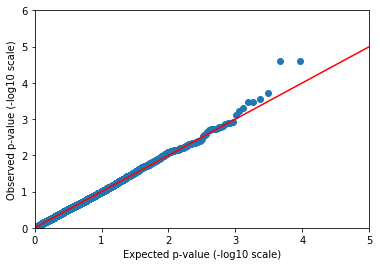

In [62]:
qqplot(pvals, 5, 6)

That's more like it! We may not be publishing ten new coffee-drinking loci in _Nature_, but we shouldn't expect to find anything but the strongest signals from a dataset of 1000 individuals anyway. 

## Rare variant analysis

Here we'll demonstrate how one can use the expression language to group and count by any arbitrary properties in variant or sample annotations. Hail also implements the sequence kernel association test (SKAT).


In [63]:
entries = ds.entries_table()
kt = (entries.group_by(pop = entries.SuperPopulation, chromosome = entries.v.contig)
      .aggregate(n_het = agg.count_where(entries.GT.is_het())))


<font color='red'>Convert to a Hail 0.1 VariantDataset, then convert to a Pandas DataFrame</font>

In [64]:
kt.to_hail1().to_dataframe().show() 

+----------+---+-----+
|chromosome|pop|n_het|
+----------+---+-----+
|        16|EAS| 4769|
|        22|SAS| 1776|
|         X|EUR| 1081|
|        10|SAS| 6704|
|        17|AFR| 4428|
|        11|EUR| 5112|
|         6|EAS| 8715|
|        20|EAS| 3975|
|        11|AMR| 3735|
|         8|EUR| 4828|
|         5|EAS| 8556|
|        20|SAS| 3713|
|        22|AMR| 1004|
|        11|SAS| 6381|
|         8|AMR| 3792|
|         4|SAS| 7984|
|        12|EAS| 6808|
|        13|AMR| 2538|
|         7|AMR| 3897|
|         3|EUR| 6660|
+----------+---+-----+
only showing top 20 rows



What if we want to group by minor allele frequency bin and hair color, and calculate the mean GQ?

In [65]:
entries = entries.annotate(maf_bin = functions.cond(entries.info.AF[0]<0.01, "< 1%", 
                              functions.cond(entries.info.AF[0]<0.05, "1%-5%", ">5%")))

kt2 = (entries.group_by(af_bin = entries.maf_bin, purple_hair = entries.PurpleHair)
      .aggregate(mean_gq = agg.stats(entries.GQ).mean, mean_dp = agg.stats(entries.DP).mean))



In [66]:
kt2.to_hail1().to_dataframe().show()

+------+-----------+------------------+------------------+
|af_bin|purple_hair|           mean_gq|           mean_dp|
+------+-----------+------------------+------------------+
|   >5%|      false|36.057763534783824|  7.51977066258284|
|  < 1%|       true|23.207061694136765| 7.548984522641973|
| 1%-5%|       true|24.166375980048606|7.4327698902997605|
|  < 1%|      false| 23.07924368253285| 7.499550788286762|
| 1%-5%|      false|24.268524992619547|7.3977532279867635|
|   >5%|       true| 36.45369778494109|7.5749512639607985|
+------+-----------+------------------+------------------+



We've shown that it's easy to aggregate by a couple of arbitrary statistics. This specific examples may not provide especially useful pieces of information, but this same pattern can be used to detect effects of rare variation:

 - Count the number of heterozygous genotypes per gene by functional category (synonymous, missense, or loss-of-function) to estimate per-gene functional constraint
 - Count the number of singleton loss-of-function mutations per gene in cases and controls to detect genes involved in disease

## Eplilogue

Congrats! If you've made it this far, you're perfectly primed to read the [Overview](https://hail.is/hail/overview.html)<font color='red'>no overview for hail2</font>, look through the [Hail objects](https://hail.is/hail/types.html) representing many core concepts in genetics, and check out the many Hail functions defined in the [Python API](https://hail.is/hail/api.html). If you use Hail for your own science, we'd love to hear from you on [Gitter chat](https://gitter.im/hail-is/hail) or the [discussion forum](http://discuss.hail.is).

There's also a lot of functionality inside Hail that we didn't get to in this broad overview. Things like:

 - Flexible import and export to a variety of data and annotation formats (VCF, BGEN, PLINK, JSON, TSV, ...)
 - Simulation
 - Kinship and pruning (IBD, GRM, RRM, LD)
 - Family-based tests and utilities
 - Distributed file system utilities
 - Interoperability with Python and Spark machine learning libraries
 - More!

For reference, here's the full workflow to all tutorial endpoints combined into one cell. It may take a minute! It's doing a lot of work.

In [347]:
table = hc.import_table('data/1kg_annotations.txt', impute=True).key_by('Sample')

ds = hc.read('data/1kg.vds')
ds = ds.annotate_cols(dummy = table[ds.s])
ds = ds.select_cols(*ds.dummy)
ds = methods.sample_qc(ds)
ds = ds.filter_cols((ds.sample_qc.dpMean >= 4) & (ds.sample_qc.callRate >= 0.97))
ab = ds.AD[1]/ds.AD.sum()
filter_condition_ab = ((ds.GT.is_hom_ref() & (ab <= 0.1)) |
                        (ds.GT.is_het() & (ab >= 0.25) & (ab <= 0.75)) |
                        (ds.GT.is_hom_var() & (ab >= 0.9)))
ds = ds.filter_entries(filter_condition_ab)
ds = methods.variant_qc(ds)
common_ds = ds.filter_rows(ds.variant_qc.AF > 0.01)

pca_eigenvalues, pca_scores, _ = methods.hwe_normalized_pca(common_ds)

cds = common_ds.annotate_cols(pca = pca_scores[common_ds.s])
linreg_results = methods.linreg(cds, [cds.CaffeineConsumption], cds.GT.num_alt_alleles(),
                                covariates=[cds.pca.PC1, cds.pca.PC2, cds.pca.PC3, cds.isFemale])
pvals = linreg_results.aggregate_rows(pvals=agg.collect(linreg_results.linreg.pval[0])).pvals

2018-01-17 16:07:31 Hail: INFO: Reading table to impute column types
2018-01-17 16:07:31 Hail: INFO: Finished type imputation
  Loading column `Sample' as type String (imputed)
  Loading column `Population' as type String (imputed)
  Loading column `SuperPopulation' as type String (imputed)
  Loading column `isFemale' as type Boolean (imputed)
  Loading column `PurpleHair' as type Boolean (imputed)
  Loading column `CaffeineConsumption' as type Float64 (imputed)
2018-01-17 16:07:31 Hail: WARN: Analysis warning: low complexity: expected an expression indexed by ['column', 'row'], found indices ['column']. Results will be broadcast along ['row'].
2018-01-17 16:07:32 Hail: WARN: converting OrderedRVD => OrderedRDD
2018-01-17 16:07:33 Hail: WARN: converting OrderedRVD => OrderedRDD
2018-01-17 16:07:36 Hail: INFO: Running PCA using 9169 variants.
2018-01-17 16:07:36 Hail: INFO: Running PCA with 10 components...
2018-01-17 16:08:15 Hail: WARN: Analysis warning: low complexity: expected an ex